Dataset  → 6376 images  |  feat-dim = 512
 Best 5‑fold F1 = 0.875
  • sc     → StandardScaler()
  • norm   → Normalizer()
  • pca    → passthrough
  • knn    → KNeighborsClassifier(metric='cosine', n_neighbors=15, weights='distance')
TRAIN F1 = 1.0 |  VAL F1 = 0.8784773060029283

TRAIN metrics
Accuracy : 1.0
Precision: 1.0
Recall   : 1.0
F1-score : 1.0
ROC-AUC  : 0.9546102675175958
Saved submission_knn_pretrained_binary.csv – rows: 500


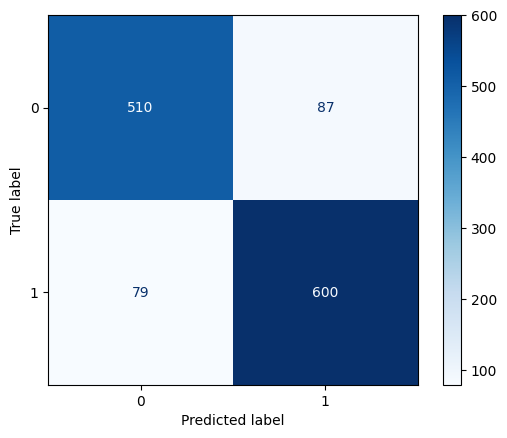

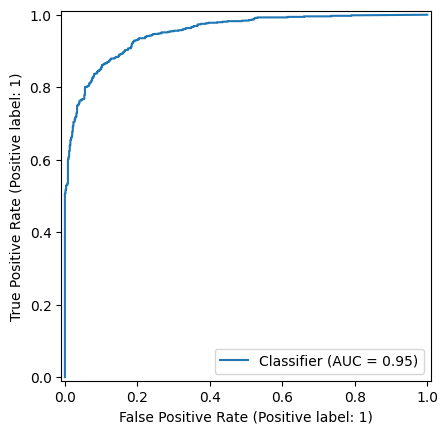

In [80]:
# ================================================================
#  ResNet‑18  ➜  k‑NN  (pleasant = 1, unpleasant = 0)
# ================================================================
import itertools, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import torch, torchvision.transforms as T, torchvision.models as models

from sklearn.preprocessing   import StandardScaler, Normalizer
from sklearn.decomposition   import PCA
from sklearn.pipeline        import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.metrics         import (f1_score, ConfusionMatrixDisplay, RocCurveDisplay)
from sklearn.metrics import accuracy_score, precision_score, recall_score

# ------------------- 0. Paths & Device -------------------------
# Define paths to training images, test images, and ID CSV
train_dir   = Path(r"C:\Users\gkara\Desktop\5th year\summer\mihaniki mathisi\train-images\train")
test_img_dir= Path(r"C:\Users\gkara\Desktop\5th year\summer\mihaniki mathisi\TEST_images\TEST_images")
ids_csv     = Path(r"C:\Users\gkara\Desktop\5th year\summer\mihaniki mathisi\Test-IDs.csv")

# Select GPU if available, otherwise use CPU
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------- 1. ResNet‑18 feature extractor ----------------
# Load pretrained ResNet-18 and remove final classification layer
resnet = models.resnet18(weights="IMAGENET1K_V1")
feat_extractor = torch.nn.Sequential(*(list(resnet.children())[:-1])).eval().to(DEVICE)

# Define image transforms: resize, normalize, convert to 3 channels
img_tf = T.Compose([
    T.Resize((224, 224)),                 # Resize to 224x224 as expected by ResNet
    T.ToTensor(),                         # Convert PIL image to tensor [0,1]
    T.Lambda(lambda x: x.repeat(3, 1, 1)),# Repeat grayscale channel to create 3 channels
    T.Normalize([0.485, 0.456, 0.406],    # Normalize using ImageNet means
                [0.229, 0.224, 0.225])    # and standard deviations
])


@torch.no_grad()
def img2feat(p: Path) -> np.ndarray:
    """
    Load image, apply transforms, extract 512-dim features with ResNet-18
    """
    img = Image.open(p).convert("L")           # Open image in grayscale
    x = img_tf(img).unsqueeze(0).to(DEVICE)      # Add batch dimension and move to DEVICE
    feats = feat_extractor(x)                    # Extract features
    return feats.squeeze().cpu().numpy()         # Remove extra dims and convert to NumPy

# ---------------- 2. Load features & labels -----------------
# Map class names to integer labels
label_map = {"unpleasant": 0, "pleasant": 1}
X, y = [], []
# Iterate over classes in fixed order to maintain label mapping
for cls in ("unpleasant", "pleasant"):     
    for img in (train_dir/cls).iterdir():         # Extract and collect features
        X.append(img2feat(img)); y.append(label_map[cls])      # Append corresponding label

# Stack feature vectors into array and convert types
X = np.vstack(X).astype("float32")            # Shape: (n_samples, 512)
y = np.array(y,  dtype="int8")                # Shape: (n_samples,)

print(f"Dataset  → {X.shape[0]} images  |  feat-dim = {X.shape[1]}")


# ----------- 3. Train / Validation split ------------------------
# Split data into 80% train and 20% validation with stratification
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, stratify=y, test_size=0.20, random_state=42)

# ------------------------------------------------------------------
# 4.  Pipeline creation (apply L2-normalization only for cosine metric)
# ------------------------------------------------------------------
def make_pipe(metric, k, use_pca):
    steps = [("sc", StandardScaler())]           # Standardize features
    if metric == "cosine":                       # For cosine distance, normalize vector length
        steps.append(("norm", Normalizer()))
    if use_pca is not None:                      
        steps.append(("pca", PCA(n_components=use_pca,
                                 whiten=False, random_state=42)))
    else:
        steps.append(("pca", "passthrough"))
    # k-NN classifier with specified metric and distance weighting
    steps.append(("knn", KNeighborsClassifier(n_neighbors=k,
                                              metric=metric,
                                              weights="distance")))
    return Pipeline(steps)

# Define hyperparameter ranges
metrics  = ["euclidean", "cosine"]
k_list   = [5, 15, 25, 35, 45]
pca_list = [None, 40, 60]           # None = skip PCA

# Setup stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_f1, best_pipe = 0, None

# Grid-search over all combinations of metric, k, and PCA dims
for metric, k, pca_dim in itertools.product(metrics, k_list, pca_list):
    pipe = make_pipe(metric, k, pca_dim)
    cv_pred = cross_val_predict(pipe, X_tr, y_tr, cv=cv, method="predict")
    f1 = f1_score(y_tr, cv_pred,average = "weighted")
    # Update best pipeline if current f1 is higher
    if f1 > best_f1:
        best_f1, best_pipe = f1, pipe

print(f" Best 5‑fold F1 = {best_f1:.3f}")
for step_name, step_obj in best_pipe.steps:
    print(f"  • {step_name:6s} → {step_obj}")

# ----------- 5. Fit pipeline on full training set ----------------
best_pipe.fit(X_tr, y_tr)

# ----------- 6. Helper for class probabilities -------------------
def probs(model, arr):
    # Identify index of class 'pleasant' in classifier's classes_
    pleasant_idx = int(np.where(model.named_steps["knn"].classes_ == 1)[0][0])
    # Return predicted probability for 'pleasant'
    return model.predict_proba(arr)[:, pleasant_idx]

# ----------- 7. Evaluate on train and validation ----------------
train_pred = best_pipe.predict(X_tr)
val_pred   = best_pipe.predict(X_val)
print("TRAIN F1 =", f1_score(y_tr, train_pred),
      "|  VAL F1 =", f1_score(y_val, val_pred))

print("\nTRAIN metrics")
print("Accuracy :", accuracy_score(y_tr, train_pred))
print("Precision:", precision_score(y_tr, train_pred))
print("Recall   :", recall_score(y_tr, train_pred))
print("F1-score :", f1_score(y_tr, train_pred))
print("ROC-AUC  :", roc_auc_score(y_tr, train_prob))

# Plot validation confusion matrix and ROC curve
ConfusionMatrixDisplay.from_predictions(y_val, val_pred, cmap="Blues")
RocCurveDisplay.from_predictions(y_val, probs(best_pipe, X_val))

# ---------- 8. Generate test submission with hard labels ---------
ids_df   = pd.read_csv(ids_csv)                  # Load test IDs
# Extract features for test images
test_feat= np.vstack([img2feat(test_img_dir/f) for f in ids_df["Filename"]])
# Compute probabilities and apply threshold
test_prob= probs(best_pipe, test_feat)          
thr = best_thr          
test_lbl = (test_prob >= thr).astype(int)       # 0 / 1

# Save submission file
pd.DataFrame({"ID": ids_df["ID"], "LABEL": test_lbl}) \
  .to_csv("submission_knn_pretrained_binary.csv", index=False)

print("Saved submission_knn_pretrained_binary.csv – rows:", len(ids_df))



torch 2.5.1
torchvision 0.20.1
CUDA available: False


Note: you may need to restart the kernel to use updated packages.


Kernel Python : C:\Users\gkara\anaconda3\python.exe
Site‑packages : C:\Users\gkara\anaconda3


C:\Users\gkara\anaconda3\envs\mlproject\python.exe
